# Import

In [1]:
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import requests
import urllib.request
import ssl
import re

from numpy.linalg import norm
from scipy.linalg import eigh

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from gensim.models import word2vec
from gensim.corpora import Dictionary

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch


In [2]:
early_modern_stopwords = pd.read_csv('early-modern-stopwords.txt', header=None)[0]

In [3]:
OHCO = ['title_id', 'act_id', 'scene_id', 'speaker_id', 'line_id']

# Get Documents, Make Base Tables

## Get Documents

In [4]:
doc_link_titles = [
    'allswell',
    'asyoulikeit',
    'comedy_errors',
    'cymbeline',
    'lll',
    'measure',
    'merry_wives',
    'merchant',
    'midsummer',
    'much_ado',
    'pericles',
    'taming_shrew',
    'tempest',
    'troilus_cressida',
    'twelfth_night',
    'two_gentlemen',
    'winters_tale',
    '1henryiv',
    '2henryiv',
    'henryv',
    '1henryvi',
    '2henryvi',
    '3henryvi',
    'henryviii',
    'john',
    'richardii',
    'richardiii',
    'cleopatra',
    'coriolanus',
    'hamlet',
    'julius_caesar',
    'lear',
    'macbeth',
    'othello',
    'romeo_juliet',
    'timon',
    'titus'
]

In [5]:
link_base = 'https://shakespeare.mit.edu/'
link_end = '/full.html'

In [6]:
doc_links = [link_base + title + link_end for title in doc_link_titles]

In [7]:
# Create an SSL context
context = ssl.create_default_context()
context.options |= ssl.OP_NO_TLSv1 | ssl.OP_NO_TLSv1_1  # Disable older versions of TLS
context.set_ciphers('DEFAULT@SECLEVEL=1')  # Set the security level

/var/folders/bh/lhwf5km11ql4b9yln2kz8ddh0000gn/T/ipykernel_35454/3760990005.py:3: DeprecationWarning: ssl.OP_NO_SSL*/ssl.OP_NO_TLS* options are deprecated
  context.options |= ssl.OP_NO_TLSv1 | ssl.OP_NO_TLSv1_1  # Disable older versions of TLS


In [8]:
doc_strings = []
for link in doc_links:
    html_file = urllib.request.urlopen(link, context=context)
    html_bytes = html_file.read()
    html_str = html_bytes.decode('utf8')
    html_file.close()
    doc_strings.append(html_str)

## Make CORPUS

In [9]:
def corpus_maker(doc_strings, OHCO, pos_bag='line_id'):
    title_ids = []
    act_ids = []
    scene_ids = []
    speaker_ids = []
    line_ids = []
    lines = []
    for doc in doc_strings: #for each document,
        title = BeautifulSoup(doc).find('title').string[:-15]
        for i in BeautifulSoup(doc).find_all('a', href=False): #for each line (in each doc),

            if re.match(r'^speech', i.attrs['name']):
                speaker = i.text #extract speaker

            else:
                title_ids.append(title)
                act_scene_line = i.attrs['name'].split('.') #extract act.scene.line
                act_ids.append(act_scene_line[0]) #append act_id
                scene_ids.append(act_scene_line[1]) #apppend scene_id
                line_ids.append(act_scene_line[2]) #append line_id
                lines.append(i.text) #append line
                speaker_ids.append(title+'_'+speaker) #append speaker
    
    df = pd.DataFrame({
        'title_id': title_ids,
        'act_id': act_ids,
        'scene_id': scene_ids,
        'speaker_id': speaker_ids,
        'line_id': line_ids,
        'line': lines}
    ).set_index(OHCO)
    
    # Get tokens and terms
    df_0 = df['line'].str.split(expand=True).stack().to_frame('token_str')
    df_0['term_str'] = df_0['token_str'].str.replace(r'\W+', '', regex=True).str.lower()
    df_0.index.names = df_0.index.names[:-1] + ['token_id']
    
    # Tag PoS
    bag_idx = OHCO.index(pos_bag) + 1
    df_pos = df_0.groupby(OHCO[:bag_idx])['token_str'].agg(lambda x: ' '.join(map(str, x))).reset_index().set_index(OHCO[:bag_idx])
    df_pos.columns = ['sent_str']
    df_pos['sent_str'] = df_pos['sent_str'].str.replace(r'[^a-zA-Z\s]', '', regex=True)
    df_pos = df_pos['sent_str'].apply(lambda x: pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)),
                                                                      dtype='object')).stack().to_frame('pos_tuple')
    
    # Final token table with POS info
    df_pos['pos'] = df_pos['pos_tuple'].apply(lambda x: x[1])
    df_pos['token_str'] = df_pos['pos_tuple'].apply(lambda x: x[0])
    df_pos['term_str'] = df_pos['token_str'].str.lower()
    df_pos['pos_group'] = df_pos['pos'].str[:2]
    df_pos.index.names = df_pos.index.names[:-1] + ['token_id']
    df_pos = df_pos.loc[:, ['token_str', 'term_str', 'pos', 'pos_group']]
    
    return df_pos

In [10]:
CORPUS = corpus_maker(doc_strings, OHCO)

In [11]:
CORPUS.head(5)

token_str  \
title_id                  act_id scene_id speaker_id                        line_id token_id             
All's Well That Ends Well 1      1        All's Well That Ends Well_BERTRAM 2       0              And   
                                                                                    1                I   
                                                                                    2               in   
                                                                                    3            going   
                                                                                    4            madam   

                                                                                             term_str  \
title_id                  act_id scene_id speaker_id                        line_id token_id            
All's Well That Ends Well 1      1        All's Well That Ends Well_BERTRAM 2       0             and   
                                                                                    1               i   
                                                                                    2              in   
                                                                                    3           going   
                                                                                    4           madam   

                                                                                              pos  \
title_id                  act_id scene_id speaker_id                        line_id token_id        
All's Well That Ends Well 1      1        All's Well That Ends Well_BERTRAM 2       0          CC   
                                                                                    1         PRP   
                                                                                    2          IN   
                                                                                    3         VBG   
                                                                                    4          JJ   

                                                                                             pos_group  
title_id                  act_id scene_id speaker_id                        line_id token_id            
All's Well That Ends Well 1      1        All's Well That Ends Well_BERTRAM 2       0               CC  
                                                                                    1               PR  
                                                                                    2               IN  
                                                                                    3               VB  
                                                                                    4               JJ

In [12]:
CORPUS.to_csv('CORPUS.csv')

## Make LIB

In [13]:
titles = []
for doc in doc_strings: #for each document,
    titles.append(BeautifulSoup(doc).find('title').string[:-15])
        
play_info = {
    'Taming of the Shrew': [1585, 'Comedy', 34],
    'Henry VI, part 2': [1591, 'History', 60],
    'Henry VI, part 3': [1592, 'History', 43],
    'Two Gentlemen of Verona': [1594, 'Comedy', 17],
    'Titus Andronicus': [1592, 'Tragedy', 24],
    'Henry VI, part 1': [1592, 'History', 54],
    'Richard III': [1593, 'History', 53],
    'Comedy of Errors': [1594, 'Comedy', 19],
    "Love's Labour's Lost": [1595, 'Comedy', 19],
    "Midsummer Night's Dream": [1595, 'Comedy', 22],
    'Romeo and Juliet': [1595, 'Tragedy', 32],
    'Richard II': [1595, 'History', 34],
    'King John': [1596, 'History', 27],
    'Merchant of Venice': [1596, 'Comedy', 22],
    'Henry IV, part 1': [1596, 'History', 34],
    'Henry IV, part 2': [1597, 'History', 52],
    'Much Ado About Nothing': [1598, 'Comedy', 23],
    'Henry V': [1599, 'History', 44],
    'As You Like It': [1599, 'Comedy', 26],
    'Julius Caesar': [1599, 'Tragedy', 47],
    'Hamlet': [1600, 'Tragedy', 30],
    'Merry Wives of Windsor': [1599, 'Comedy', 23],
    'Twelfth Night': [1601, 'Comedy', 18],
    'Troiles and Cressida': [1601, 'Comedy', 27],
    'Othello': [1604, 'Tragedy', 25],
    'Measure for Measure': [1604, 'Comedy', 23],
    "All's Well That Ends Well": [1604, 'Comedy', 22],
    'Timon of Athens': [1605, 'Tragedy', 48],
    'King Lear': [1605, 'Tragedy', 25],
    'Macbeth': [1606, 'Tragedy', 38],
    'Antony and Cleopatra': [1606, 'Tragedy', 53],
    'Coriolanus': [1608, 'Tragedy', 49],
    'Pericles': [1608, 'Comedy', 43],
    'Cymbeline': [1610, 'Comedy', 37],
    "Winter's Tale": [1611, 'Comedy', 33],
    'The Tempest': [1611, 'Comedy', 19],
    'Henry VIII': [1613, 'History', 43]
} 
written_years = {key: values[0] for key, values in play_info.items()}
genres = {key: values[1] for key, values in play_info.items()}
n_characters = {key: values[2] for key, values in play_info.items()}
# these years are the middle of the range for a given play,
# rounded down (i.e. 1593/1594 -> 1593)
# https://www.rsc.org.uk/shakespeares-plays/histories-timeline/timeline (source)
# https://www.statista.com/statistics/1061409/character-count-shakespeare-plays/

LIB = pd.DataFrame({
    'title_id': titles,
    'link': doc_links
})
# get additional features of the texts
LIB['year_written'] = LIB['title_id'].map(written_years)
LIB['genre'] = LIB['title_id'].map(genres)
LIB['n_characters'] = LIB['title_id'].map(n_characters)
LIB['monarch'] = LIB['year_written'].apply(lambda x: 'Elizabeth I' if x < 1603 else 'James I')

LIB = LIB.merge(CORPUS.reset_index().groupby(['title_id'])['act_id'].nunique(),
                on='title_id') # get n_acts
LIB = LIB.merge(CORPUS.reset_index().groupby(['title_id', 'act_id'])['scene_id'].nunique().groupby(['title_id']).sum(),
                on='title_id') #get n_scenes
LIB = LIB.merge(CORPUS.reset_index().groupby(['title_id', 'act_id', 'scene_id'])['line_id'].nunique().groupby(['title_id']).sum(),
                on='title_id') #get n_lines
LIB = LIB.merge(CORPUS.reset_index().groupby(['title_id', 'act_id', 'scene_id', 'line_id'])['token_id'].nunique().groupby(['title_id']).sum(),
                on='title_id') #get n_tokens
LIB = LIB.merge(CORPUS['term_str'].str.len().groupby('title_id').sum(),
                on='title_id') #get n_chars

LIB.columns = list(LIB.columns[:6]) + ['n_acts', 'n_scenes', 'n_lines', 'n_tokens', 'n_chars']
LIB = LIB.set_index('title_id')
LIB.sample(5)

,link,year_written,genre,n_characters,monarch,n_acts,n_scenes,n_lines,n_tokens,n_chars
title_id,,,,,,,,,,
Winter's Tale,https://shakespeare.mit.edu/winters_tale/full....,1611,Comedy,33,James I,5,14,3362,24509,99562
"Henry VI, part 1",https://shakespeare.mit.edu/1henryvi/full.html,1592,History,54,Elizabeth I,5,27,2766,20593,88281
"Henry IV, part 2",https://shakespeare.mit.edu/2henryiv/full.html,1597,History,52,Elizabeth I,6,20,3249,25839,105891
Twelfth Night,https://shakespeare.mit.edu/twelfth_night/full...,1601,Comedy,18,Elizabeth I,5,18,2483,19417,76295
"Henry IV, part 1",https://shakespeare.mit.edu/1henryiv/full.html,1596,History,34,Elizabeth I,5,18,3038,23921,96725


In [14]:
LIB.to_csv('LIB.csv')

# Make Derived Tables

## Make VOCAB

In [15]:
def get_vocab(TOKENS):
    VOCAB = TOKENS.term_str.value_counts().to_frame('n').sort_index()
    VOCAB.index.name = 'term_str'
    VOCAB['n_chars'] = VOCAB.index.str.len()
    VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
    VOCAB['i'] = -np.log2(VOCAB.p)
    VOCAB['max_pos'] = TOKENS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
    VOCAB['max_group'] = VOCAB['max_pos'].str[:2]
    
    # Calculate DFIDF
    BOW = TOKENS.groupby(OHCO+['term_str'])['term_str'].count().to_frame('n')
    DTCM = BOW['n'].unstack(fill_value=0)
    DF = DTCM.astype('bool').sum()
    IDF = np.log2(DTCM.shape[0]/DF)
    
    # Merge VOCAB w/ DFIDF
    dfidf = DF*IDF
    dfidf.name = 'dfidf'
    VOCAB = VOCAB.merge(dfidf, on='term_str')
    
    # Porter Stemming
    stemmer = PorterStemmer()
    VOCAB['porter_stem'] = VOCAB.apply(lambda x: stemmer.stem(x.name), 1)
    
    # Stopword Boolean
    stop_words = list(stopwords.words('english'))
    stop_words = stop_words + list(early_modern_stopwords)
    VOCAB['stop'] = VOCAB.apply(lambda x: x.name in stop_words, axis=1)
    
    return VOCAB

In [16]:
VOCAB = get_vocab(CORPUS)

In [17]:
VOCAB.head()

,n,n_chars,p,i,max_pos,max_group,dfidf,porter_stem,stop
term_str,,,,,,,,,
a,13766,1,0.016944,5.883071,DT,DT,38997.523237,a,True
aaron,25,5,0.000031,14.988037,NNP,NN,291.332922,aaron,False
aarons,1,6,0.000001,19.631893,NNP,NN,16.723834,aaron,False
abaissiez,1,9,0.000001,19.631893,NN,NN,16.723834,abaissiez,False
abandon,3,7,0.000004,18.046930,IN,IN,45.416615,abandon,False


In [18]:
VOCAB[~VOCAB.stop].sort_values('dfidf', ascending=False).head(20).index

Index(['good', 'lord', 'come', 'let', 'ill', 'love', 'man', 'say', 'know',
       'make', 'tis', 'king', 'speak', 'tell', 'think', 'time', 'heart',
       'great', 'hear', 'art'],
      dtype='object', name='term_str')

In [19]:
VOCAB.to_csv('VOCAB.csv')

## BOW, DTM, TFIDF, TFIDF (reduced & normed)

In [20]:
def computed_from_corpus(CORPUS, VOCAB, bow_bag, TF_type, top_n=1000):
    # Create BOW from CORPUS based on the bag
    bag_idx = OHCO.index(bow_bag) + 1
    BOW = CORPUS.groupby(OHCO[:bag_idx]+['term_str'])['term_str'].count().to_frame('n')
    BOW = BOW.reset_index().merge(VOCAB.reset_index()[['term_str', 'stop', 'max_pos']], on='term_str', how='left')
    BOW = BOW[~BOW['stop']]
    BOW = BOW[BOW['max_pos'].str.match(r'^(?!NNP$).*')]
    BOW = BOW.set_index(OHCO[:bag_idx]+['term_str'])[['n']]
    
    # Create DTM from CORPUS based on bag
    DTM = BOW['n'].unstack(fill_value=0)
    
    # Create TFIDF table from DTM
    #compute TF
    if TF_type == 'sum':
        TF = DTM.T / DTM.T.sum()
    elif TF_type == 'max':
        TF = DTM.T / DTM.T.max()
    elif TF_type == 'log':
        TF = np.log2(1 + DTM.T)
    elif TF_type == 'double_norm':
        TF = DTM.T / DTCM.T.max()
    elif TF_type == 'raw':
        TF = DTM.T
    elif TF_type == 'binary':
        TF = DTM.T.astype('bool').astype('int')
    TF = TF.T
    
    #compute IDF
    DF = DTM.astype('bool').sum()
    N = DTM.shape[0]
    IDF = np.log2(N / DF) #standard IDF method
    
    TFIDF = TF * IDF
    
    #add tfidf to BOW
    tfidf_long = pd.melt(TFIDF.reset_index(), id_vars=OHCO[:bag_idx], value_vars=list(TFIDF.columns), value_name='tfidf')
    BOW['tfidf'] = tfidf_long.query("tfidf > 0").sort_values(OHCO[:bag_idx]+['term_str']).set_index(OHCO[:bag_idx]+['term_str'])['tfidf'].values
    
    # Create Normalized TFIDF, Filtered to top_n words with highest DFIDF values
    top_n = (DF*IDF).sort_values(ascending=False).head(top_n).index
    TFIDF_n = TFIDF.T.loc[top_n].T.groupby(OHCO[:bag_idx]).mean()
    TFIDF_norm = TFIDF_n.apply(lambda x: x / norm(x), 1)
    
    return BOW, DTM, TFIDF, TFIDF_norm

In [21]:
BOW, DTM, TFIDF, TFIDF_norm = computed_from_corpus(CORPUS, VOCAB, 'scene_id', 'sum', top_n=2000)

### BOW

In [22]:
BOW.sample(5)

,,,,n,tfidf
title_id,act_id,scene_id,term_str,,
Two Gentlemen of Verona,3,1,harbour,2,0.010639
The Tempest,3,2,nought,1,0.009448
King John,5,2,clippeth,1,0.016809
Coriolanus,1,9,grieves,1,0.019226
Cymbeline,1,6,pay,1,0.004393


In [23]:
BOW.to_csv('BOW.csv')

### DTM

In [24]:
DTM.sample(5)

,,term_str,abaissiez,abandon,abandond,abandoned,abandonwhich,abase,abashd,abate,abated,abatement,...,zed,zenith,zephyrs,zir,zo,zodiac,zodiacs,zone,zounds,zwaggered
title_id,act_id,scene_id,,,,,,,,,,,,,,,,,,,,,
Midsummer Night's Dream,2,2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
King Lear,3,4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Macbeth,4,2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Richard III,4,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cymbeline,4,3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
DTM.to_csv('DTM.csv')

### TFIDF

In [26]:
TFIDF.sample(5)

,,term_str,abaissiez,abandon,abandond,abandoned,abandonwhich,abase,abashd,abate,abated,abatement,...,zed,zenith,zephyrs,zir,zo,zodiac,zodiacs,zone,zounds,zwaggered
title_id,act_id,scene_id,,,,,,,,,,,,,,,,,,,,,
Much Ado About Nothing,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Richard III,5,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043016,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Henry IV, part 2",5,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hamlet,3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
King Lear,4,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
TFIDF.to_csv('TFIDF.csv')

### TFIDF_norm

In [28]:
TFIDF_norm.sample(5)

,,term_str,heaven,set,honour,long,gone,hold,night,hast,bring,word,...,aspect,aloud,yesterday,nation,beget,contented,shield,charm,signify,sue
title_id,act_id,scene_id,,,,,,,,,,,,,,,,,,,,,
As You Like It,1,3,0.023688,0.000000,0.023858,0.000000,0.023434,0.023434,0.000000,0.023183,0.000000,0.048932,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Much Ado About Nothing,4,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025104,0.026589,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Richard III,1,2,0.044089,0.074011,0.014802,0.014644,0.014539,0.000000,0.014435,0.014383,0.000000,0.030358,...,0.102884,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Richard II,3,2,0.075527,0.015214,0.000000,0.000000,0.014943,0.000000,0.044510,0.014783,0.000000,0.015602,...,0.000000,0.0,0.052874,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Julius Caesar,5,1,0.000000,0.024287,0.024287,0.024027,0.023855,0.000000,0.000000,0.000000,0.000000,0.024905,...,0.000000,0.0,0.000000,0.0,0.0,0.084404,0.0,0.0,0.0,0.0


In [29]:
TFIDF_norm.to_csv('TFIDF_norm.csv')

## PCA

In [30]:
def pca(TFIDF, k, norm_docs=True):
    if norm_docs:
        TFIDF = (TFIDF.T / norm(TFIDF, 2, axis=1)).T
    
    COV = TFIDF.cov()
    eig_vals, eig_vecs = eigh(COV)
    
    EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_str'
    
    EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)
    EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)
    
    #component information table
    COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(k).reset_index(drop=True)
    COMPS.index.name = 'comp_id'
    COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]
    COMPS.index.name = 'pc_id'
    
    #loadings table
    LOADINGS = COMPS[COV.index].T
    LOADINGS.index.name = 'term_str'
    
    #document-component matrix
    DCM = TFIDF.dot(COMPS[COV.index].T)
    DCM = DCM.join(LIB, on='title_id')
    
    return LOADINGS, COMPS, DCM

In [31]:
LOADINGS, COMPONENTS, DCM = pca(TFIDF_norm, 10, norm_docs=True) #have to run on a smaller dataset (too intense on full corpus)

### COMPONENTS

In [32]:
COMPONENTS.head()

,eig_val,heaven,set,honour,long,gone,hold,night,hast,bring,...,aloud,yesterday,nation,beget,contented,shield,charm,signify,sue,exp_var
pc_id,,,,,,,,,,,,,,,,,,,,,
PC0,0.012688,-0.080897,-0.022671,-0.075170,-0.034083,-0.022060,-0.020094,-0.019924,-0.055249,0.005158,...,-0.008767,0.004606,-0.006241,-0.009206,-0.010599,0.003302,-0.005674,-0.007300,-0.011872,1.38
PC1,0.011685,-0.008359,0.014512,0.001855,-0.006988,-0.024231,-0.021963,-0.033112,-0.017333,-0.010819,...,0.004799,-0.010090,0.009699,0.007570,0.002681,0.004904,-0.001747,-0.002760,0.004273,1.27
PC2,0.007861,0.007443,-0.000483,0.005992,-0.005691,0.033174,-0.005796,0.014283,-0.014079,-0.001621,...,0.006163,-0.013441,-0.017807,0.001899,-0.010236,0.006386,-0.001126,-0.003828,-0.007772,0.86
PC3,0.007283,-0.039081,-0.013204,0.035082,0.026424,-0.003671,-0.017015,-0.085212,-0.051402,-0.007268,...,-0.012882,-0.002633,0.008183,-0.002717,0.010826,-0.004228,-0.028167,0.001199,0.010298,0.79
PC4,0.006458,0.022741,0.000875,-0.099598,0.006380,0.014991,-0.008952,0.029464,0.042250,-0.003546,...,0.001934,-0.004698,-0.010887,0.009132,0.006581,0.008074,0.011758,0.002178,-0.007770,0.70


In [33]:
COMPONENTS.drop(['eig_val', 'exp_var'], axis=1).loc['PC0'].sort_values(ascending=False).head()

master    0.065835
horse     0.050669
doctor    0.046622
host      0.036544
fight     0.034038
Name: PC0, dtype: float64

In [34]:
COMPONENTS.drop(['eig_val', 'exp_var'], axis=1).loc['PC1'].sort_values().head()

master     -0.292141
mistress   -0.183403
madam      -0.150634
fool       -0.129273
love       -0.119670
Name: PC1, dtype: float64

In [35]:
COMPONENTS.to_csv('COMPONENTS.csv')

### DCM

In [36]:
DCM.head()

PC0       PC1       PC2  \
title_id                  act_id scene_id                                 
All's Well That Ends Well 1      1        -0.375290 -0.146813  0.133864   
                                 2        -0.236006 -0.055082 -0.026107   
                                 3        -0.386022 -0.251245  0.313043   
                          2      1        -0.369959 -0.039427 -0.082131   
                                 2        -0.160624 -0.108364 -0.019635   

                                                PC3       PC4       PC5  \
title_id                  act_id scene_id                                 
All's Well That Ends Well 1      1        -0.009953 -0.043073 -0.113192   
                                 2        -0.035226 -0.076126  0.067472   
                                 3         0.086415  0.064103 -0.187677   
                          2      1        -0.026187 -0.141393 -0.040918   
                                 2         0.084178 -0.107573 -0.030254   

                                                PC6       PC7       PC8  \
title_id                  act_id scene_id                                 
All's Well That Ends Well 1      1         0.043491  0.006160 -0.117178   
                                 2         0.035094 -0.006853 -0.088637   
                                 3         0.065048 -0.069719 -0.121471   
                          2      1         0.024771 -0.051868 -0.098449   
                                 2         0.106937 -0.031248  0.034120   

                                                PC9  \
title_id                  act_id scene_id             
All's Well That Ends Well 1      1         0.011655   
                                 2        -0.050412   
                                 3        -0.019570   
                          2      1        -0.099258   
                                 2         0.056766   

                                                                                     link  \
title_id                  act_id scene_id                                                   
All's Well That Ends Well 1      1         https://shakespeare.mit.edu/allswell/full.html   
                                 2         https://shakespeare.mit.edu/allswell/full.html   
                                 3         https://shakespeare.mit.edu/allswell/full.html   
                          2      1         https://shakespeare.mit.edu/allswell/full.html   
                                 2         https://shakespeare.mit.edu/allswell/full.html   

                                           year_written   genre  n_characters  \
title_id                  act_id scene_id                                       
All's Well That Ends Well 1      1                 1604  Comedy            22   
                                 2                 1604  Comedy            22   
                                 3                 1604  Comedy            22   
                          2      1                 1604  Comedy            22   
                                 2                 1604  Comedy            22   

                                           monarch  n_acts  n_scenes  n_lines  \
title_id                  act_id scene_id                                       
All's Well That Ends Well 1      1         James I       5        23     2925   
                                 2         James I       5        23     2925   
                                 3         James I       5        23     2925   
                          2      1         James I       5        23     2925   
                                 2         James I       5        23     2925   

                                           n_tokens  n_chars  
title_id                  act_id scene_id                     
All's Well That Ends Well 1      1            22554    90604  
                                 2            22554    90604  
                                 3          

/Users/silashayes/anaconda3/lib/python3.11/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



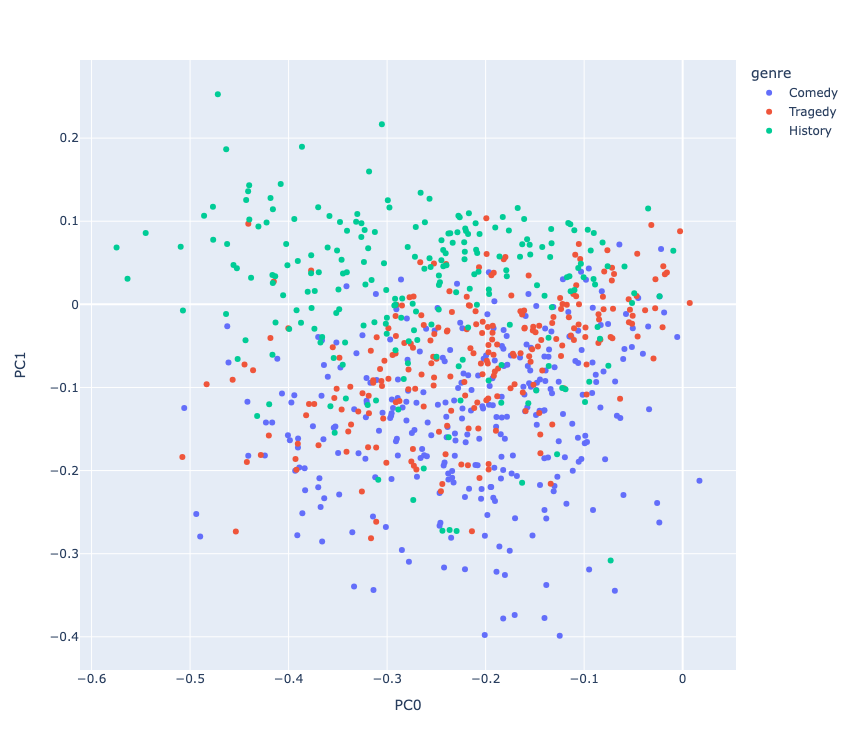

In [96]:
px.scatter(DCM.reset_index(), x='PC0', y='PC1', color='genre', hover_name='title_id',
          width=750, height=750)

/Users/silashayes/anaconda3/lib/python3.11/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



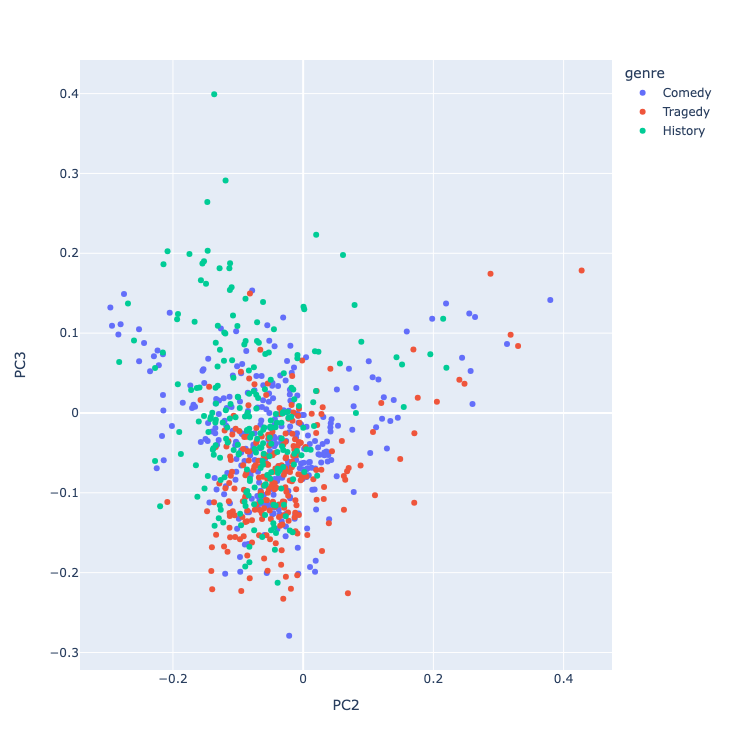

In [38]:
px.scatter(DCM.reset_index(), x='PC2', y='PC3', color='genre', hover_name='title_id',
          width=750, height=750)

In [39]:
DCM.to_csv('DCM.csv')

### LOADINGS

In [40]:
LOADINGS.head()

pc_id,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
term_str,,,,,,,,,,
heaven,-0.080897,-0.008359,0.007443,-0.039081,0.022741,-0.012856,-0.042080,-0.007833,0.033012,-0.051424
set,-0.022671,0.014512,-0.000483,-0.013204,0.000875,-0.026750,0.037277,-0.001129,-0.011759,-0.013879
honour,-0.075170,0.001855,0.005992,0.035082,-0.099598,-0.025205,-0.009781,-0.013964,-0.054833,-0.015984
long,-0.034083,-0.006988,-0.005691,0.026424,0.006380,-0.004547,0.011653,0.006178,0.008273,-0.010673
gone,-0.022060,-0.024231,0.033174,-0.003671,0.014991,-0.030227,-0.024709,-0.009033,0.025805,-0.023145


In [41]:
VOCAB

,n,n_chars,p,i,max_pos,max_group,dfidf,porter_stem,stop
term_str,,,,,,,,,
a,13766,1,0.016944,5.883071,DT,DT,38997.523237,a,True
aaron,25,5,0.000031,14.988037,NNP,NN,291.332922,aaron,False
aarons,1,6,0.000001,19.631893,NNP,NN,16.723834,aaron,False
abaissiez,1,9,0.000001,19.631893,NN,NN,16.723834,abaissiez,False
abandon,3,7,0.000004,18.046930,IN,IN,45.416615,abandon,False
...,...,...,...,...,...,...,...,...,...
zodiac,1,6,0.000001,19.631893,NN,NN,16.723834,zodiac,False
zodiacs,1,7,0.000001,19.631893,NNS,NN,16.723834,zodiac,False
zone,1,4,0.000001,19.631893,NN,NN,16.723834,zone,False


In [42]:
def vis_loadings(a=0, b=1, hover_name='term_str'):
    # X = LOADINGS.join(VOCAB)
    X = LOADINGS.join(VOCAB)
    return px.scatter(X.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', size='i', #color='genre', 
                      height=750, width=750)

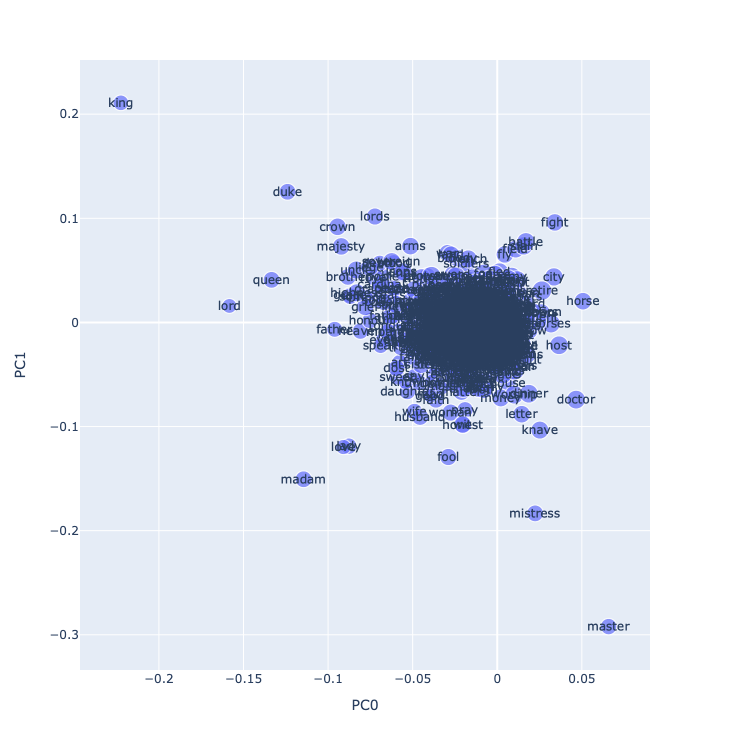

In [43]:
vis_loadings(0, 1)

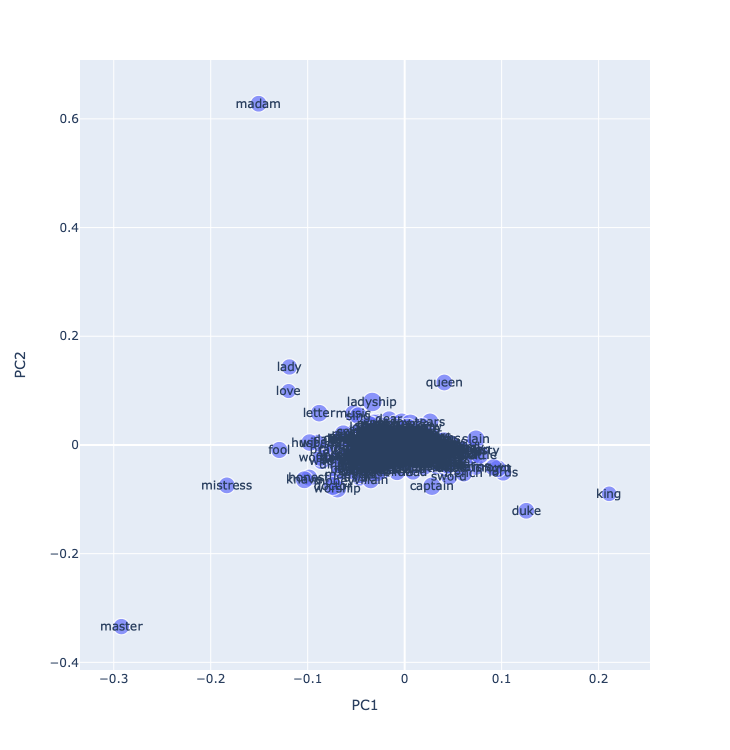

In [44]:
vis_loadings(1, 2)

In [45]:
LOADINGS.to_csv('LOADINGS.csv')

## LDA

In [46]:
def lda(CORPUS, VOCAB, bow_bag, n_topics):
    bag_idx = OHCO.index(bow_bag) + 1
    #filter to nouns, verbs, and adjectives only but also remove personal nouns
    CORPUS = CORPUS[(CORPUS.pos.str.match(r'^(?!NNP$).*')) & (CORPUS.pos_group.str.match(r'[VB]|[NN]'))]
    CORPUS = CORPUS.reset_index().merge(VOCAB.reset_index()[['term_str', 'stop']], on='term_str', how='left')
    CORPUS = CORPUS[~CORPUS['stop']]
    DOCS = CORPUS\
        .groupby(OHCO[:bag_idx]).term_str\
        .apply(lambda x: ' '.join(x))\
        .to_frame()\
        .rename(columns={'term_str':'doc_str'})
    
    count_engine = CountVectorizer(max_features=4000, ngram_range=(1, 2), stop_words='english')
    count_model = count_engine.fit_transform(DOCS.doc_str)
    TERMS = count_engine.get_feature_names_out()

    VOCAB = pd.DataFrame(index=TERMS)
    VOCAB.index.name = 'term_str'

    DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)
    global COUNT_MATRIX_LDA
    COUNT_MATRIX_LDA = DTM
    
    lda_engine = LDA(n_components=n_topics, max_iter=5, learning_offset=50., random_state=0)
    lda_model = lda_engine.fit_transform(count_model)
    
    #make theta table (bag-topic)
    global TNAMES
    TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

    THETA = pd.DataFrame(lda_model, index=DOCS.index)
    THETA.columns.name = 'topic_id'
    THETA.columns = TNAMES
    
    #make phi table (topic-term)
    PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
    PHI.index.name = 'topic_id'
    PHI.columns.name = 'term_str'
    
    # make topic table
    TOPICS = PHI.stack().groupby('topic_id')\
        .apply(lambda x: ' '.join(x.sort_values(ascending=False).head(10).reset_index().term_str))\
        .to_frame('top_terms')
    
    return THETA, PHI, TOPICS

In [47]:
THETA, PHI, TOPICS = lda(CORPUS, VOCAB, 'scene_id', 25)

### THETA

In [48]:
THETA.head()

T00       T01       T02  \
title_id                  act_id scene_id                                 
All's Well That Ends Well 1      1         0.000086  0.000086  0.000086   
                                 2         0.000253  0.000253  0.000253   
                                 3         0.000074  0.000074  0.000074   
                          2      1         0.000086  0.000086  0.382826   
                                 2         0.000342  0.000342  0.291611   

                                                T03       T04       T05  \
title_id                  act_id scene_id                                 
All's Well That Ends Well 1      1         0.000086  0.000086  0.000086   
                                 2         0.000253  0.000253  0.000253   
                                 3         0.000074  0.000074  0.000074   
                          2      1         0.400379  0.000086  0.000086   
                                 2         0.000342  0.000342  0.000342   

                                                T06       T07       T08  \
title_id                  act_id scene_id                                 
All's Well That Ends Well 1      1         0.000086  0.000086  0.000086   
                                 2         0.000253  0.000253  0.000253   
                                 3         0.000074  0.000074  0.000074   
                          2      1         0.000086  0.000086  0.000086   
                                 2         0.000342  0.000342  0.000342   

                                                T09  ...       T15       T16  \
title_id                  act_id scene_id            ...                       
All's Well That Ends Well 1      1         0.000086  ...  0.000086  0.997944   
                                 2         0.000253  ...  0.000253  0.000253   
                                 3         0.000074  ...  0.000074  0.000074   
                          2      1         0.000086  ...  0.000086  0.000086   
                                 2         0.000342  ...  0.000342  0.000342   

                                                T17       T18       T19  \
title_id                  act_id scene_id                                 
All's Well That Ends Well 1      1         0.000086  0.000086  0.000086   
                                 2         0.000253  0.000253  0.000253   
                                 3         0.000074  0.841959  0.000074   
                          2      1         0.000086  0.000086  0.000086   
                                 2         0.000342  0.000342  0.173597   

                                                T20       T21       T22  \
title_id                  act_id scene_id                                 
All's Well That Ends Well 1      1         0.000086  0.000086  0.000086   
                                 2         0.000253  0.000253  0.000253   
                                 3         0.000074  0.156337  0.000074   
                          2      1         0.000086  0.000086  0.000086   
                                 2         0.000342  0.000342  0.000342   

                                                T23       T24  
title_id                  act_id scene_id                      
All's Well That Ends Well 1      1         0.000086  0.000086  
                                 2         0.993924  0.000253  
                                 3         0.000074  0.000074  
                          2      1         0.000086  0.000086  
                                 2         0.000342  0.000342  

[5 rows x 25 columns]

In [49]:
THETA.to_csv('THETA.csv')

### PHI

In [50]:
PHI.head()

term_str,abed,abhor,abide,aboard,absence,absent,absolute,abundance,abuse,abused,...,yields,yoke,yon,yond,yonder,youll,youre,youth,zeal,zounds
topic_id,,,,,,,,,,,,,,,,,,,,,
T00,0.040000,0.040000,0.040000,0.040000,1.111955,0.040000,0.103134,0.040000,0.04000,0.123588,...,0.040000,0.040000,0.040000,0.040000,0.041972,0.040000,0.040000,0.040000,0.040000,0.040000
T01,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.04000,0.040000,...,0.040000,0.040000,0.040000,0.040000,1.040000,0.040000,0.040000,0.040000,0.040000,0.040000
T02,0.040000,0.040000,0.040000,0.040000,1.276590,0.040000,0.040000,0.040000,1.04000,0.040000,...,0.040000,0.040000,0.040000,1.679537,2.398008,1.047696,0.040000,7.721933,1.623013,0.040000
T03,2.379610,2.612703,7.562131,1.824685,12.334522,1.092888,0.040529,2.817949,9.08789,3.178027,...,0.138558,8.508703,0.491798,2.641592,0.737033,11.337060,15.000237,19.049087,8.299471,1.418879
T04,1.973439,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.04000,0.040000,...,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,1.131782,0.040000,0.040000


In [51]:
PHI.to_csv('PHI.csv')

### PCA ON PHI

In [104]:
pca_engine_phi = PCA(2)
# pca(TFIDF, k, norm_docs=True)

In [105]:
PHI_COMPS = pd.DataFrame(pca_engine_phi.fit_transform(normalize(PHI, norm='l2', axis=1)), index=PHI.index)
PHI_COMPS.columns = ['PC0', 'PC1']
PHI_COMPS['mean_doc_weight'] = THETA.mean()
PHI_COMPS['max_doc'] = THETA.idxmax().apply(lambda x: x[0])
PHI_COMPS = PHI_COMPS.merge(LIB.reset_index(), left_on='max_doc', right_on='title_id', how='left').drop('max_doc', axis=1)
PHI_COMPS.index = PHI_COMPS.index.to_series().apply(lambda x: 'T{:02d}'.format(x)).rename('topic_id')
PHI_COMPS = PHI_COMPS.merge(TOPICS, on='topic_id')
PHI_COMPS['top_3'] = PHI_COMPS['top_terms'].str.split().apply(lambda x: x[:3])

/Users/silashayes/anaconda3/lib/python3.11/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



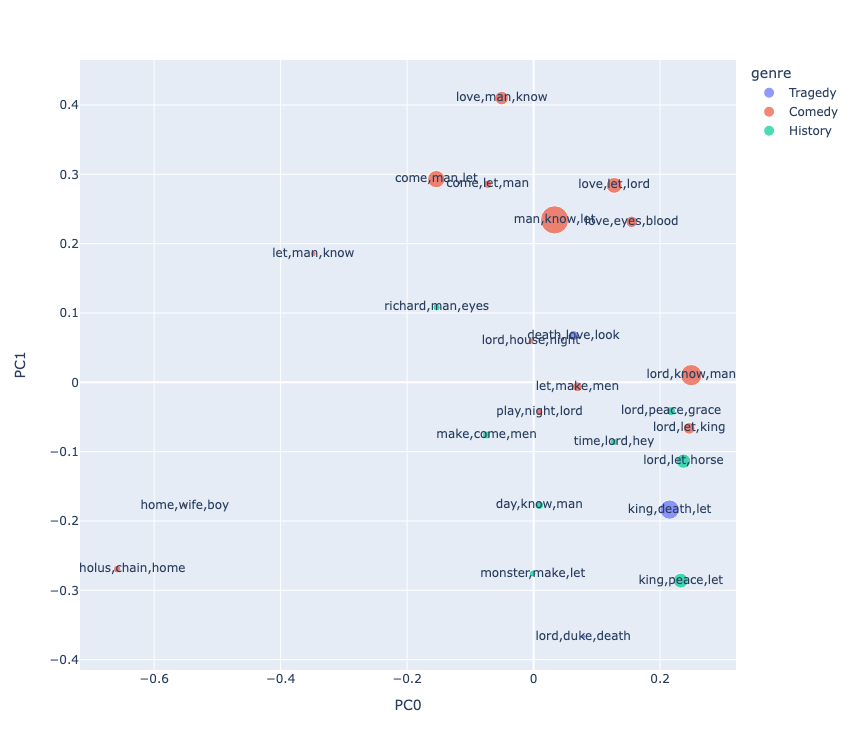

In [108]:
px.scatter(PHI_COMPS, x='PC0', y='PC1', size='mean_doc_weight',
           color='genre', text='top_3',
           height=750, width=750)

### TOPICS

In [55]:
TOPICS.head()

,top_terms
topic_id,
T00,lord duke death friar husband life woman left ...
T01,play night lord knave day leek man let make say
T02,let make men come say life know gold news look
T03,lord know man come let speak make time say love
T04,day know man thane hail king father let days men


In [56]:
for i in range(5):
    print(TOPICS.head()['top_terms'].iloc[i].split()[:5])

['lord', 'duke', 'death', 'friar', 'husband']
['play', 'night', 'lord', 'knave', 'day']
['let', 'make', 'men', 'come', 'say']
['lord', 'know', 'man', 'come', 'let']
['day', 'know', 'man', 'thane', 'hail']


In [57]:
TOPICS.to_csv('TOPICS.csv')

In [58]:
COUNT_MATRIX_LDA.to_csv('COUNT_MATRIX_LDA.csv')

## Sentiment

In [59]:
def combine_sentiment(SENTIMENT, TABLE):
    if 'stop' in TABLE.columns:
        TABLE = TABLE[~TABLE['stop']] #remove stopwords
    COMBO = TABLE.reset_index().merge(SENTIMENT.reset_index(), how='inner', on='term_str')
    COMBO_idx = COMBO.set_index('term_str')
    if 'title_id' in COMBO.columns:
        COMBO_idx = COMBO.set_index(OHCO[:1]+['term_str'])
        if 'act_id' in COMBO.columns:
            COMBO_idx = COMBO.set_index(OHCO[:2]+['term_str'])
            if 'scene_id' in COMBO.columns:
                COMBO_idx = COMBO.set_index(OHCO[:3]+['term_str'])
                if 'speaker_id' in COMBO.columns:
                    COMBO_idx = COMBO.set_index(OHCO[:4]+['term_str'])
                    if 'line_id' in COMBO.columns:
                        COMBO_idx = COMBO.set_index(OHCO+['term_str'])
    return COMBO_idx

In [60]:
def sentiment_per_bag(BOW_SENT, bow_bag):
    bag_idx = OHCO.index(bow_bag) + 1
    return BOW_SENT.groupby(OHCO[:bag_idx]).mean()

In [61]:
salex_csv = 'data/lexicons/salex_nrc.csv'
emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()
SALEX = pd.read_csv(salex_csv).set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]

In [62]:
VOCAB_SENT = combine_sentiment(SALEX, VOCAB)
VOCAB_SENT.head(5)

,n,n_chars,p,i,max_pos,max_group,dfidf,porter_stem,stop,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
term_str,,,,,,,,,,,,,,,,,,,,
abandon,3,7,0.000004,18.046930,IN,IN,45.416615,abandon,False,0,0,0,1,0,1,0,1,0,0,-1
abandoned,2,9,0.000002,18.631893,VBD,VB,31.447668,abandon,False,1,0,0,1,0,1,0,1,0,0,-1
abhor,17,5,0.000021,15.544430,VBP,VB,214.818314,abhor,False,1,0,1,1,0,1,0,0,0,0,-1
abject,11,6,0.000014,16.172461,JJ,JJ,145.908429,abject,False,0,0,1,0,0,1,0,0,0,0,-1
abominable,15,10,0.000018,15.725002,JJ,JJ,192.254155,abomin,False,0,0,1,1,0,1,0,0,0,0,-1


In [63]:
VOCAB_SENT.to_csv('VOCAB_SENT.csv')

In [64]:
BOW_SENT = combine_sentiment(SALEX, BOW)
BOW_SENT.head(5)

n     tfidf  anger  \
title_id                  act_id scene_id term_str                        
All's Well That Ends Well 1      1        abandoned  1  0.012376      1   
                                          abundance  1  0.009021      0   
                                          advise     1  0.006237      0   
                                          ambition   2  0.012586      0   
                                          bleak      1  0.010086      0   

                                                     anticipation  disgust  \
title_id                  act_id scene_id term_str                           
All's Well That Ends Well 1      1        abandoned             0        0   
                                          abundance             1        1   
                                          advise                0        0   
                                          ambition              1        0   
                                          bleak                 0        0   

                                                     fear  joy  negative  \
title_id                  act_id scene_id term_str                         
All's Well That Ends Well 1      1        abandoned     1    0         1   
                                          abundance     0    1         1   
                                          advise        0    0         0   
                                          ambition      0    1         0   
                                          bleak         0    0         1   

                                                     positive  sadness  \
title_id                  act_id scene_id term_str                       
All's Well That Ends Well 1      1        abandoned         0        1   
                                          abundance         1        0   
                                          advise            1        0   
                                          ambition          1        0   
                                          bleak             0        1   

                                                     surprise  trust  \
title_id                  act_id scene_id term_str                     
All's Well That Ends Well 1      1        abandoned         0      0   
                                          abundance         0      1   
                                          advise            0      1   
                                          ambition          0      1   
                                          bleak             0      0   

                                                     sentiment  
title_id                  act_id scene_id term_str              
All's Well That Ends Well 1      1        abandoned         -1  
                                          abundance          0  
                                          advise             1  
                                          ambition           1  
                                          bleak             -1

In [65]:
BOW_SENT.to_csv('BOW_SENT.csv')

In [66]:
DOC_SENT = sentiment_per_bag(BOW_SENT, 'scene_id')
DOC_SENT.head(10)

n     tfidf     anger  \
title_id                  act_id scene_id                                 
All's Well That Ends Well 1      1         1.650943  0.008670  0.216981   
                                 2         1.180000  0.018439  0.200000   
                                 3         1.697248  0.006433  0.247706   
                          2      1         1.396396  0.006993  0.225225   
                                 2         1.607143  0.024664  0.214286   
                                 3         1.574803  0.005394  0.251969   
                                 4         1.166667  0.024233  0.083333   
                                 5         1.425000  0.015216  0.175000   
                          3      1         1.000000  0.047342  0.083333   
                                 2         1.480769  0.011177  0.346154   

                                           anticipation   disgust      fear  \
title_id                  act_id scene_id                                     
All's Well That Ends Well 1      1             0.292453  0.216981  0.226415   
                                 2             0.260000  0.140000  0.160000   
                                 3             0.256881  0.211009  0.302752   
                          2      1             0.333333  0.180180  0.270270   
                                 2             0.357143  0.178571  0.250000   
                                 3             0.291339  0.196850  0.259843   
                                 4             0.500000  0.125000  0.125000   
                                 5             0.375000  0.150000  0.275000   
                          3      1             0.250000  0.083333  0.166667   
                                 2             0.326923  0.250000  0.403846   

                                                joy  negative  positive  \
title_id                  act_id scene_id                                 
All's Well That Ends Well 1      1         0.311321  0.471698  0.528302   
                                 2         0.360000  0.380000  0.640000   
                                 3         0.302752  0.513761  0.495413   
                          2      1         0.369369  0.441441  0.549550   
                                 2         0.357143  0.428571  0.535714   
                                 3         0.370079  0.464567  0.535433   
                                 4         0.583333  0.375000  0.708333   
                                 5         0.375000  0.325000  0.675000   
                          3      1         0.083333  0.583333  0.416667   
                                 2         0.288462  0.538462  0.442308   

                                            sadness  surprise     trust  \
title_id                  act_id scene_id                                 
All's Well That Ends Well 1      1         0.292453  0.141509  0.481132   
                                 2         0.220000  0.180000  0.520000   
                                 3         0.321101  0.137615  0.458716   
                          2      1         0.225225  0.153153  0.423423   
                                 2         0.142857  0.214286  0.428571   
                                 3         0.251969  0.165354  0.440945   
                                 4         0.250000  0.291667  0.458333   
                                 5         0.175000  0.225000  0.650000   
                          3      1         0.333333  0.166667  0.416667   
                                 2         0.346154  0.250000  0.326923   

                                           sentiment  
title_id                  act_id scene_id             
All's Well That Ends Well 1      1          0.056604  
                                 2          0.260000  
                                 3         -0.018349  
                          2      1          0.108108  
                                 2          0.107143  
             

In [67]:
DOC_SENT.to_csv('DOC_SENT.csv')

In [68]:
DOC_SENT.loc['Hamlet'].reset_index().head()

,act_id,scene_id,n,tfidf,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
0,1,1,1.256757,0.009991,0.364865,0.283784,0.135135,0.405405,0.283784,0.540541,0.445946,0.283784,0.189189,0.297297,-0.094595
1,1,2,1.677083,0.006320,0.177083,0.260417,0.125000,0.281250,0.343750,0.458333,0.510417,0.260417,0.156250,0.416667,0.052083
2,1,3,1.385714,0.011624,0.200000,0.271429,0.157143,0.271429,0.371429,0.428571,0.557143,0.171429,0.171429,0.500000,0.128571
3,1,4,1.114286,0.016971,0.285714,0.200000,0.342857,0.371429,0.228571,0.628571,0.371429,0.200000,0.057143,0.342857,-0.257143
4,1,5,1.784810,0.009359,0.354430,0.240506,0.278481,0.379747,0.265823,0.582278,0.417722,0.278481,0.202532,0.278481,-0.164557


In [111]:
def sentiment_graph(df, title_id):
    play = df.loc[title_id].reset_index()
    play['act_scene'] = play.apply(lambda x: str(x['act_id']) + ", " + str(x['scene_id']), axis=1)
    fig = px.line(play, x=play.index, y='sentiment', text='act_scene', title=title_id,
                 height=400)
    fig.update_traces(textposition="bottom center")
    return fig

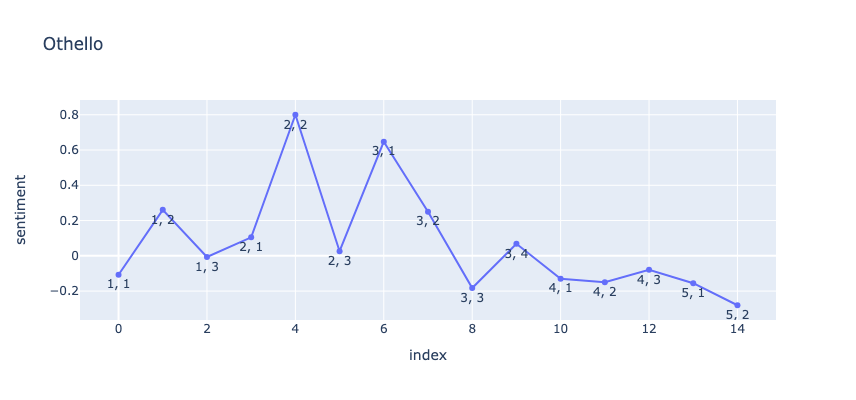

In [112]:
sentiment_graph(DOC_SENT, "Othello")

Act II, Scene 2 is a high point because it is extremely short and only involves one speech in which a herald announces that Othello plans on celebrating his marriage to Desdemona and Cyprus's safety. From here, the play goes decidedly downhill as Iago manipulates and controls the other characters into orchestrating Othello's worst nightmare as he murders his love, Desdemona.

## Word2vec

In [71]:
def gensim_corpora(CORPUS, bow_bag):
    bag_idx = OHCO.index(bow_bag) + 1
    docs = CORPUS[~CORPUS.pos.str.match('NNPS?')].dropna(subset='term_str')\
        .groupby(OHCO[:bag_idx])\
        .term_str.apply(lambda  x:  x.tolist())\
        .reset_index()['term_str'].tolist()
    docs = [doc for doc in docs if len(doc) > 1] # Lose single word docs
    
    return docs

In [72]:
def get_vector(row, model):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        vec = None
    return vec

In [73]:
def vocab_w2v(VOCAB, DOCS, params):
    model = word2vec.Word2Vec(DOCS, **params)
    WV = pd.DataFrame(VOCAB.apply(get_vector, model=model, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)
    
    return WV

In [132]:
def tsne_from_w2v(WV, VOCAB, tsne_engine):
    tsne_model = tsne_engine.fit_transform(WV.to_numpy())
    tsne = pd.DataFrame(tsne_model, columns=['x','y'], index=WV.index)
    X = tsne.join(VOCAB[['n', 'max_group', 'stop', 'dfidf']], how='left')
    X = X.sort_values('dfidf', ascending=False).head(400)
    X['log_n'] = np.log(X['n'])
    
    #filter to only nouns & verbs, exclude stopwords
    X = X[(X['max_group'].isin(['NN', 'VB'])) & (~X['stop'])].drop('stop', axis=1)
    
    return X

In [133]:
DOCS = gensim_corpora(CORPUS, 'speaker_id')

In [134]:
params = dict(
    window = 2,
    vector_size = 256,
    min_count = 100
)

In [135]:
VOCAB_W2V = vocab_w2v(VOCAB, DOCS, params)
VOCAB_W2V.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
term_str,,,,,,,,,,,,,,,,,,,,,
war,0.122892,-0.191628,-0.037531,-0.017209,0.226261,-0.119528,0.019040,-0.013803,-0.073469,0.334424,...,0.152465,-0.078725,-0.554448,-0.023428,-0.045946,0.043881,-0.228154,0.060327,-0.257091,-0.024517
lets,-0.197281,-0.379278,0.181559,-0.000004,0.102512,0.026694,0.062031,-0.196838,0.305909,-0.023216,...,-0.193453,0.029306,-0.040348,-0.115128,-0.304138,-0.112785,-0.248241,0.056872,-0.333946,0.101730
see,-0.341701,-0.238268,0.172420,0.174424,0.176818,0.038551,-0.308822,-0.108323,-0.157540,-0.083259,...,0.113492,-0.158738,0.144968,-0.087221,-0.098855,-0.096645,-0.151702,-0.020641,0.193786,0.020252
those,0.186149,-0.229985,0.027632,-0.057426,0.037080,-0.190445,-0.105810,0.046319,-0.066643,0.468479,...,-0.190510,-0.067876,-0.358100,-0.076945,-0.154189,0.012865,-0.114824,-0.260241,-0.423106,-0.212814
us,-0.081982,-0.279969,0.360877,-0.140069,0.141626,-0.212970,0.232886,-0.033645,-0.068742,0.248124,...,-0.113921,-0.113229,-0.779990,-0.353074,-0.468528,0.114495,-0.453795,0.122284,-0.380503,0.407153


In [136]:
VOCAB_W2V.to_csv('VOCAB_W2V.csv')


In [137]:
tsne_engine = TSNE(learning_rate=200, perplexity=20,
                   n_components=2, init='random',
                   max_iter=1000, random_state=42)


In [138]:
TSNEDF = tsne_from_w2v(VOCAB_W2V, VOCAB, tsne_engine)


In [139]:
TSNEDF.head()


,x,y,n,max_group,dfidf,log_n
term_str,,,,,,
lord,30.180809,-15.597747,2763,NN,14373.861796,7.924072
come,-34.501587,-2.271911,2549,NN,12927.446597,7.843456
let,-24.557665,-27.607718,2095,VB,11778.007918,7.647309
ill,-6.799027,-8.778850,1987,NN,11286.363883,7.594381
love,-25.080704,-14.408790,1896,NN,10762.868928,7.547502


/Users/silashayes/anaconda3/lib/python3.11/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



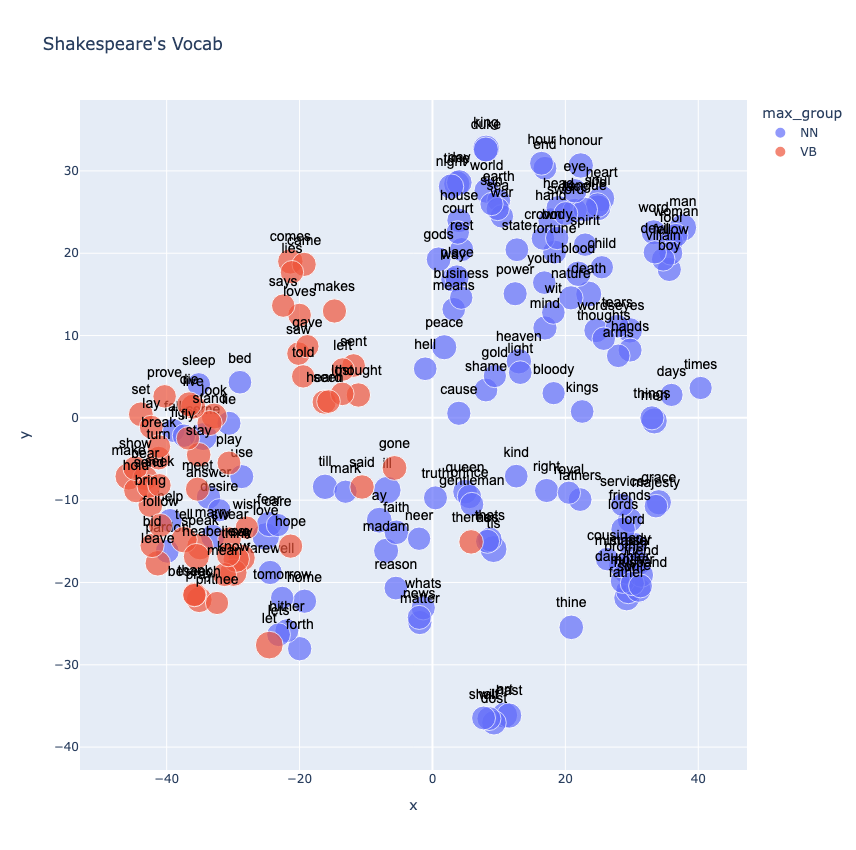

In [140]:
px.scatter(TSNEDF.reset_index(), 'x', 'y', 
           text='term_str', 
           color='max_group', 
           hover_name='term_str',          
           size='log_n',
           title="Shakespeare's Vocab",
           width=850,
           height=850).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

# Riffs

### Hierarchical Clustering

In [83]:
# Create dataframe with cartesian product of books by books
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([LIB.index.tolist(), LIB.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['doc_a', 'doc_b']

In [84]:
PLAY_TFIDF = TFIDF.groupby('title_id').mean()
L0 = PLAY_TFIDF.astype('bool').astype('int') # Binary (Pseudo L)
L1 = PLAY_TFIDF.apply(lambda x: x / x.sum(), 1) # Probabilistic
L2 = PLAY_TFIDF.apply(lambda x: x / norm(x), 1) # Pythagorean, AKA Euclidean

In [85]:
PAIRS['cityblock'] = pdist(PLAY_TFIDF, 'cityblock')
PAIRS['euclidean'] = pdist(PLAY_TFIDF, 'euclidean')
PAIRS['cosine'] = pdist(PLAY_TFIDF, 'cosine')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['dice'] = pdist(L0, 'dice')
PAIRS['js'] = pdist(L1, 'jensenshannon')  
# PAIRS['euclidean2'] = pdist(L2, 'euclidean') # Should be the same as cosine (colinear)

In [141]:
def hac(sims, linkage_method='complete', color_thresh=.3, figsize=(10, 10)):

    # Generate the clustering
    tree = sch.linkage(sims, method=linkage_method)
    
    # Get labels for the leaves
    labels = LIB.index.values
    
    # Create a figure 
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    
    # Create a dendrogram with the tree
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    
    # Change the appearance of ticks, tick labels, and gridlines
    plt.tick_params(axis='both', which='major', labelsize=14)
    return fig

<Figure size 640x480 with 0 Axes>

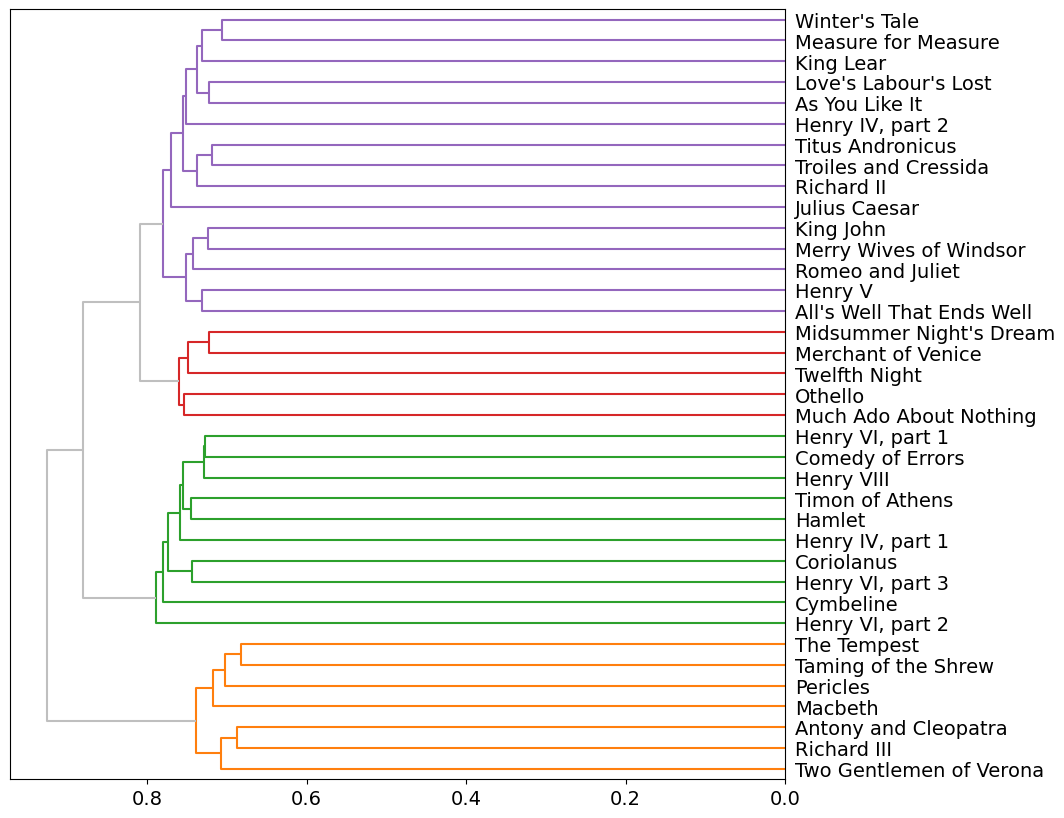

In [147]:
dendrogram = hac(PAIRS.jaccard, linkage_method='ward', color_thresh=0.8)
dendrogram.savefig('Riff1_Dendrogram.png')


In [88]:
#cosine, 0.9, not great
#js, 0.72, not great
#dice, 0.67, better I think
#cityblock, 6.8, not great
#euclidean is bad
#jaccard, 0.8, also better

### Word Association Heatmap

In [89]:
interested_words = ['man', 'woman', 'lord', 'lady', 'king', 'queen', 'master', 'mistress',
                   'beauty', 'love', 'knave', 'sword', 'heart', 'time', 'life', 'death']

In [90]:
# Create dataframe with cartesian product of words by words
WORD_PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([interested_words, interested_words])).reset_index()
WORD_PAIRS = WORD_PAIRS[WORD_PAIRS.level_0 < WORD_PAIRS.level_1].set_index(['level_0','level_1'])
WORD_PAIRS.index.names = ['word_a', 'word_b']

In [91]:
WORD_PAIRS['cosine'] = pdist(VOCAB_W2V.loc[interested_words], 'cosine')

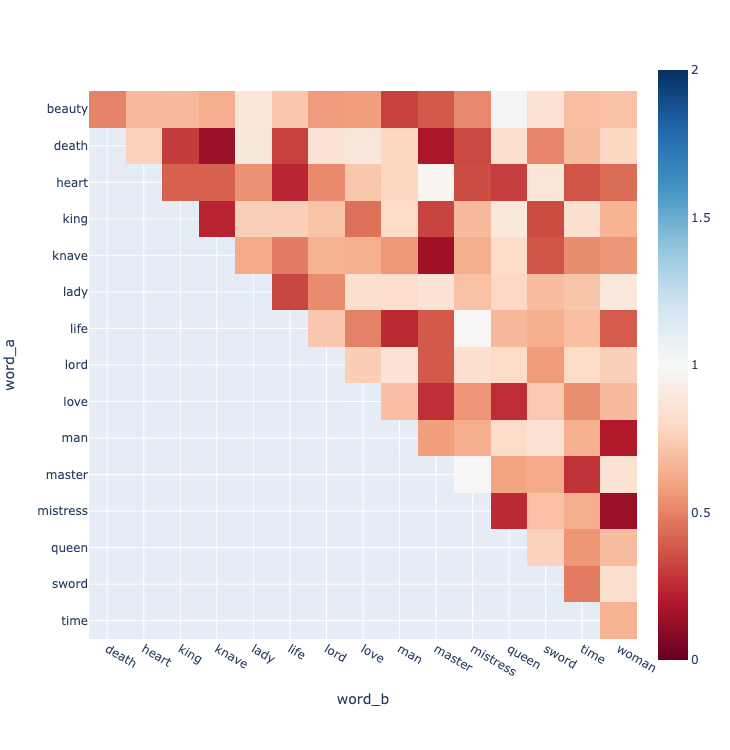

In [92]:
px.imshow(WORD_PAIRS.reset_index().pivot(index='word_a', columns='word_b', values='cosine'),
          color_continuous_scale=px.colors.sequential.RdBu,
          zmin=0, zmax=2,
          width=750, height=750)

### Riff 3

In [93]:
def genre_sentiment_graph(df, alpha):
    df = df.reset_index().merge(LIB, on='title_id')
    df['scene_number'] = df.groupby(['title_id'])['scene_id'].transform(lambda x: range(1, len(x) + 1))
    
    for title, group in df.groupby('title_id'):
        min_val = group['scene_number'].min()
        max_val = group['scene_number'].max()
        df.loc[df['title_id'] == title, 'normalized_scene_number'] = ((group['scene_number'] - min_val) / (max_val - min_val))
    
    fig = px.scatter(df, x='normalized_scene_number', y='sentiment', color='genre',
                     hover_data=["title_id"],
                     trendline="lowess", trendline_options=dict(frac=alpha),
                    width=750, height=550)
    fig.update_traces(marker_size=3)
    return fig

/Users/silashayes/anaconda3/lib/python3.11/site-packages/plotly/express/_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



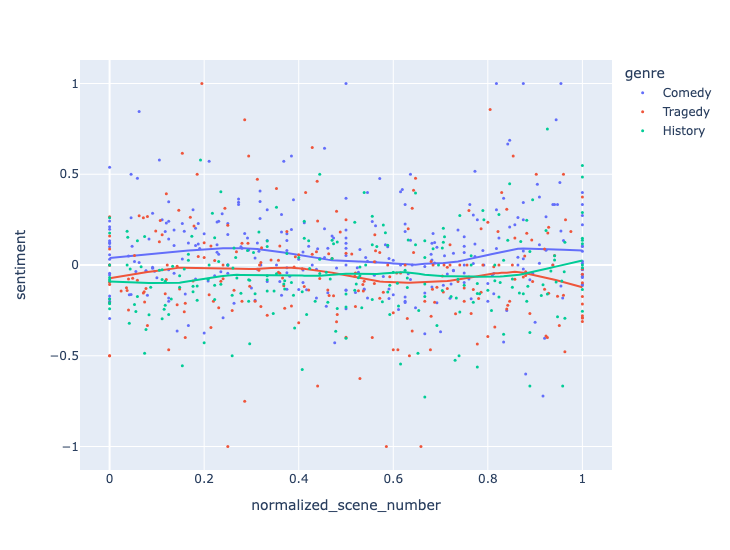

In [94]:
genre_sentiment_graph(DOC_SENT, 0.3)